Quantum Chemistry in Python
===============

In this lesson we will explore how to perform Quantum Chemistry computations from Python,
as well as several data science applications within the field of quantum chemistry.  To do 
this, we will utilize the quantum chemistry package Psi4, which has a Python front end and 
API, as well as several Python libraries for data analysis, visualization, and machine 
learning. 

## Quantum Chemistry Basics

The goal of the field of quantum chemistry is to model, predict, and describe chemical behavior
from first principles using quantum mechanics.  To do so exactly is computaionally impossible
for all but the smallest atomic and molecular systems, due to the exponential cost of solving
the exact electronic Schrodinger equation.  Therefore, in quantum chemistry, we employ approximate
methods which
* are _computationally tractible_ for "real" chemical systems of interest and 
* provide an _accurate description of the chemical behavior_ to be studied.


In [5]:
# ==> Import libraries <==
import psi4                               # Quantum chemistry package 
import time                               # For timing code
import numpy as np                        # Numerical operations
import pandas as pd                       # Data handling
import seaborn as sns                     # Plotting & visualization
import matplotlib.pyplot as plt           # Plotting & visualization
import utilities.plotting as fancyplt     # Custom library for advanced plots

idx = pd.IndexSlice                       # Slice pandas.DataFrame objects across multiindex

# Matplotlib plots within notebook
%matplotlib inline

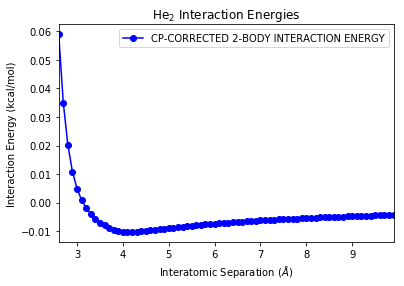

In [6]:
# ==> Example 1: Construct He...He Potential Curve <==

# Define atomic coordinates for He dimer
He_dimer = """
0 1
He 0 0 0    # First He at the origin
--
He 0 0 {}   # Other He displaced along z-axis

units angstrom
"""

psivariables = {}

# Iterate over He...He separation distances in z axis
for r in np.arange(2.6, 10, 0.1):
    mol = psi4.geometry(He_dimer.format(r))                      # Create Psi4 molecule with displaced He dimer
    ie = psi4.energy('b3lyp-d3mbj/aug-cc-pvdz', bsse_type='cp')  # Compute CP-corrected interaction energy
    psivariables[r] = psi4.core.variables()                      # Save Psi4 internal variables

b3lypdf = pd.DataFrame(data=psivariables).T # Store Psi4 internal variables inside Pandas DataFrame
b3lypdf *= psi4.constants.hartree2kcalmol   # Convert energy units from atomic units (Hartree) to kcal/mol

# Plot potential curve directly from Pandas dataframe
plot_options = {'style': 'bo-',
                'title': 'He$_2$ Interaction Energies',
                'legend': True
               }

b3lypdf['CP-CORRECTED 2-BODY INTERACTION ENERGY'].plot(**plot_options)
plt.xlabel('Interatomic Separation ($\AA$)')
plt.ylabel('Interaction Energy (kcal/mol)')

# Save dataframe to disk for future use
b3lypdf.to_pickle('data/He2-b3lyp-d3mbj-curve.pkl')

Text(0, 0.5, 'Interaction Energy (kcal/mol)')

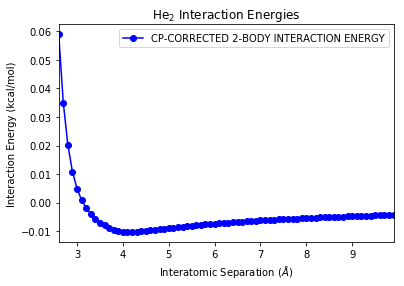

In [7]:
# ==> Plot IE curve directly from Pandas <==
plot_options = {'style': 'bo-',
                'title': 'He$_2$ Interaction Energies',
                'legend': True
               }

b3lypdf['CP-CORRECTED 2-BODY INTERACTION ENERGY'].plot(**plot_options)
plt.xlabel('Interatomic Separation ($\AA$)')
plt.ylabel('Interaction Energy (kcal/mol)')

## Improving QC Model Accuracy using Transfer Learning

### Symmetry-Adapted Perturbation Theory: Physically Motivated Interaction Energies from First Principles

Symmetry-Adapted Perturbation Theory (SAPT) can provide a more chemically intuitive description of intermolecular interaction energies by providing a breakdown of the IE into phisically meaningful components:

$$ IE_{\rm SAPT0} = E_{\rm elst} + E_{\rm exch} + E_{\rm ind} + E_{\rm disp} $$

To illustrate this method, we can visualize the total IE and components of our Helium dimer using SAPT:

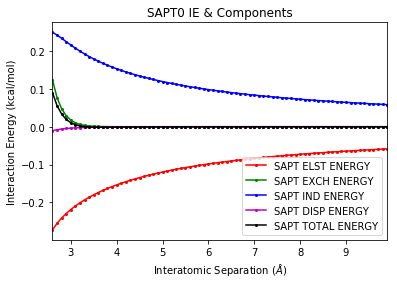

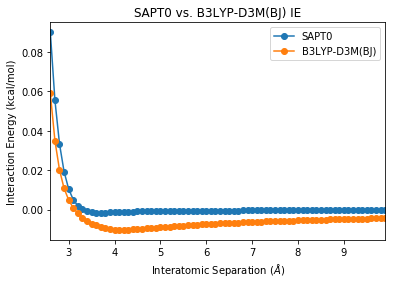

In [8]:
# ==> Example 02: SAPT IE & Components for He2 <==

# Compute SAPT IE for He2 along potential curve
for r in np.arange(2.6, 10, 0.1):
    mol = psi4.geometry(He_dimer.format(r))                      # Create Psi4 molecule with displaced He dimer
    ie = psi4.energy('sapt0/jun-cc-pvdz', molecule=mol)          # Compute SAPT IE
    psivariables[r] = psi4.core.variables()                      # Save Psi4 internal variables

saptdf = pd.DataFrame(data=psivariables).T      # Store Psi4 internal variables inside Pandas DataFrame
saptdf *= psi4.constants.hartree2kcalmol        # Convert energy units from atomic units (Hartree) to kcal/mol

# Visualize SAPT components along potential scan
terms = {'SAPT ELST ENERGY': 'ro-',
         'SAPT EXCH ENERGY': 'go-',
         'SAPT IND ENERGY': 'bo-',
         'SAPT DISP ENERGY': 'mo-',
         'SAPT TOTAL ENERGY': 'ko-'
        }

saptdf[terms.keys()].plot(style=list(terms.values()), markersize=2)
plt.xlabel('Interatomic Separation ($\AA$)')
plt.ylabel('Interaction Energy (kcal/mol)')
plt.title('SAPT0 IE & Components')

# Plot SAPT IE vs. B3LYP-D3M(BJ) IE
df = pd.concat([saptdf['SAPT TOTAL ENERGY'], b3lypdf['CP-CORRECTED 2-BODY INTERACTION ENERGY']], axis=1)
df.columns = ['SAPT0', 'B3LYP-D3M(BJ)']
df.plot(style='o-')
plt.xlabel('Interatomic Separation ($\AA$)')
plt.ylabel('Interaction Energy (kcal/mol)')
plt.title('SAPT0 vs. B3LYP-D3M(BJ) IE')

# Save SAPT data for later 
saptdf.to_pickle('data/He2-sapt0-curve.pkl')

Text(0.5, 1.0, 'SAPT0 vs. B3LYP-D3M(BJ) IE')

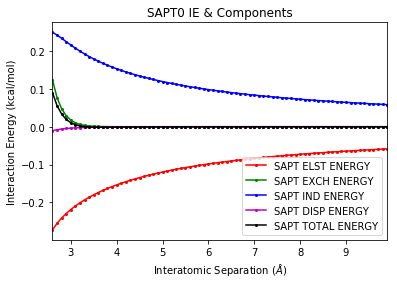

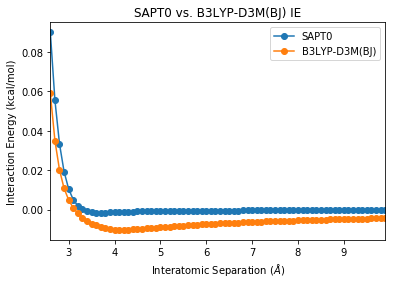

In [9]:
# ==> Visualize the components of SAPT along potential scan <==

terms = {'SAPT ELST ENERGY': 'ro-',
         'SAPT EXCH ENERGY': 'go-',
         'SAPT IND ENERGY': 'bo-',
         'SAPT DISP ENERGY': 'mo-',
         'SAPT TOTAL ENERGY': 'ko-'
        }

saptdf[terms.keys()].plot(style=list(terms.values()), markersize=2)
plt.xlabel('Interatomic Separation ($\AA$)')
plt.ylabel('Interaction Energy (kcal/mol)')
plt.title('SAPT0 IE & Components')

# Plot SAPT IE vs. B3LYP-D3M(BJ) IE
df = pd.concat([saptdf['SAPT TOTAL ENERGY'], b3lypdf['CP-CORRECTED 2-BODY INTERACTION ENERGY']], axis=1)
df.columns = ['SAPT0', 'B3LYP-D3M(BJ)']
df.plot(style='o-')
plt.xlabel('Interatomic Separation ($\AA$)')
plt.ylabel('Interaction Energy (kcal/mol)')
plt.title('SAPT0 vs. B3LYP-D3M(BJ) IE')

### SAPT0-D: A More Efficient SAPT Approach

For large molecules the SAPT approach can become prohibitively expensive, because the cost of computing the SAPT energy scales as $N^5$, where $N$ is proportional to the total number of atoms. To illustrate this, consider the following set of computations computing the interaction between two growing chains of He atoms:

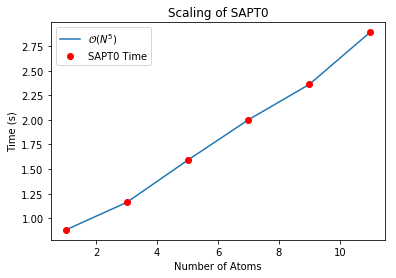

In [10]:
# ==> Visualize N^5 SAPT Scaling <==
chainA = ['He 0 0 0\n', 'He 0 0 2\n', 'He 0 0 4\n', 'He 0 0 6\n', 'He 0 0 8\n', 'He 0 0 10\n']
chainB = ['He 0 3 0\n', 'He 0 3 3\n', 'He 0 3 4\n', 'He 0 3 6\n', 'He 0 3 8\n', 'He 0 3 10\n']

molstr = """
0 1
{}
--
0 1
{}

units angstrom
"""

monoA = ''
monoB = ''
times = []
natoms = []
for i in range(len(chainA)):
    monoA += chainA[i]
    monoB += chainB[i]
    t0 = time.time()
    psi4.energy('sapt0/jun-cc-pvdz', mol=psi4.geometry(molstr.format(monoA, monoB)))
    times.append(time.time() - t0)
    natoms.append(2 * i + 1)
    
# Plot time versus number of atoms, fit to N^5 curve
f = np.poly1d(np.polyfit(natoms, times, deg=5))
plt.plot(natoms, f(natoms), label='${\cal O}(N^5)$')
plt.plot(natoms, times, 'ro', label='SAPT0 Time', zorder=10)
plt.title('Scaling of SAPT0')
plt.xlabel('Number of Atoms')
plt.ylabel('Time (s)')
plt.legend()

The term responsible for the ${\cal O}(N^5)$ scaling of SAPT0 is the dispersion term,
$E_{\rm disp}$, whereas all other terms scale as ${\cal O}(N^4)$. We could therefore 
seemingly reduce the computational scaling of SAPT0 by an order of magnitude by simply
neglecting the dispersion term.  But how could such an approach still produce accurate
interaction energies?

We may be in luck! There exist empirical "dispersion corrections" which have been proposed
to approximately add long-range electron correlation (the physical phenomenon responsible
for the dispersion interaction) to mean-field quantum chemical methods like Density Functional
Theory which are (either partially or entirely) neglecting this effect.  Importantly, methods
which employ these dispersion corrections satisfy both of our desired properties in quantum
chemistry: in general, the dispersion-corrected method acheives higher accuracy in the same 
amount of time as the uncorrected version of the method. This increased accuracy is achieved
by training the empirical model to reproduce high-quality references, computed using methods
which are _significantly_ more expensive than the model being corrected.  Most often, these
reference energies are computed using the quantum chemical "gold standard," CCSD(T). 

So, instead of simply abandoning the expensive SAPT0 dispersion, let's replace it with an 
empirical dispersion correction that can be parameterized to reproduce very high accuracy
interaction energies!  We'll refer to this method as SAPT0-D, for "dispersion-corrected SAPT0".

In [11]:
# Import SAPT, SAPT-D, & CCSD(T) Data
saptd = pd.read_pickle('data/saptd-full.pkl')

print(saptd.shape)
saptd.head()

(8084, 33)


D3M          \
                                                            Benchmark   SAPT0   
DB   System                                             R                       
ACHC a-c nucleobase complex at -0.4 slide (A) and 0.... 1.0    -6.396 -6.2297   
     a-c nucleobase complex at -0.8 slide (A) and 0.... 2.0    -6.245  -5.988   
     a-c nucleobase complex at -1.2 slide (A) and 0.... 3.0    -6.069 -5.8144   
     a-c nucleobase complex at -1.6 slide (A) and 0.... 4.0     -6.09 -6.0028   
     a-c nucleobase complex at -12.0 tilt (deg) and ... 3.0    -5.382 -5.3261   

                                                                              \
                                                             SAPTHF     Disp   
DB   System                                             R                      
ACHC a-c nucleobase complex at -0.4 slide (A) and 0.... 1.0  4.1514 -10.3811   
     a-c nucleobase complex at -0.8 slide (A) and 0.... 2.0  4.1716 -10.1596   
     a-c nucleobase complex at -1.2 slide (A) and 0.... 3.0  3.9283  -9.7427   
     a-c nucleobase complex at -1.6 slide (A) and 0.... 4.0  3.1738  -9.1766   
     a-c nucleobase complex at -12.0 tilt (deg) and ... 3.0  3.4721  -8.7982   

                                                                             \
                                                               Elst     Ind   
DB   System                                             R                     
ACHC a-c nucleobase complex at -0.4 slide (A) and 0.... 1.0 -2.8105 -1.3542   
     a-c nucleobase complex at -0.8 slide (A) and 0.... 2.0 -2.9389 -1.3018   
     a-c nucleobase complex at -1.2 slide (A) and 0.... 3.0  -3.086 -1.2205   
     a-c nucleobase complex at -1.6 slide (A) and 0.... 4.0 -3.2686 -1.1476   
     a-c nucleobase complex at -12.0 tilt (deg) and ... 3.0  -2.151 -1.0939   

                                                                      \
                                                               Zero3   
DB   System                                             R              
ACHC a-c nucleobase complex at -0.4 slide (A) and 0.... 1.0 -10.9247   
     a-c nucleobase complex at -0.8 slide (A) and 0.... 2.0 -10.7699   
     a-c nucleobase complex at -1.2 slide (A) and 0.... 3.0 -10.4031   
     a-c nucleobase complex at -1.6 slide (A) and 0.... 4.0 -9.84067   
     a-c nucleobase complex at -12.0 tilt (deg) and ... 3.0 -9.34336   

                                                                         \
                                                            SAPT0-Zero3   
DB   System                                             R                 
ACHC a-c nucleobase complex at -0.4 slide (A) and 0.... 1.0   -6.773324   
     a-c nucleobase complex at -0.8 slide (A) and 0.... 2.0   -6.598297   
     a-c nucleobase complex at -1.2 slide (A) and 0.... 3.0   -6.474755   
     a-c nucleobase complex at -1.6 slide (A) and 0.... 4.0   -6.666872   
     a-c nucleobase complex at -12.0 tilt (deg) and ... 3.0   -5.871261   

                                                                               \
                                                            SAPT0-Zero3 Error   
DB   System                                             R                       
ACHC a-c nucleobase complex at -0.4 slide (A) and 0.... 1.0          0.377324   
     a-c nucleobase complex at -0.8 slide (A) and 0.... 2.0          0.353297   
     a-c nucleobase complex at -1.2 slide (A) and 0.... 3.0          0.405755   
     a-c nucleobase complex at -1.6 slide (A) and 0.... 4.0          0.576872   
     a-c nucleobase complex at -12.0 tilt (deg) and ... 3.0          0.489261   

                                                                         ...  \
                                                            SAPT0 Error  ...   
DB   System                                             R                ...   
ACHC a-c nucleobase complex at -0.4 slide (A) and 0.... 1.0     -0.1663  ...

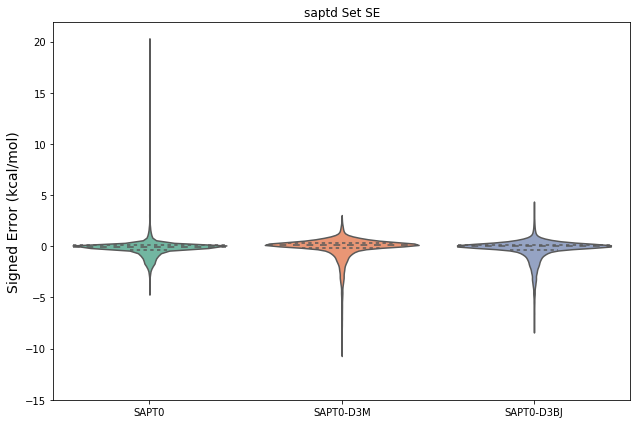

In [12]:
# ==> Plotting Signed Errors for SAPT0 & SAPT0-D vs. CCSD(T) <==

rawdata=pd.concat([saptd.loc[:,idx['D3M',['SAPT0 Error','Benchmark']]], saptd.loc[:,idx[:,['SAPT0-Zero3 Error', 'SAPT0-BJ Error', 'SAPT0-TT Error']]]], axis=1)

# Filter outliers?
rawdata = rawdata[abs(rawdata.loc[:,idx['D3M','Benchmark']]) >= 1.e-6]
data=rawdata

se = pd.DataFrame(index=data.index, columns=['SAPT0','SAPT0-D3M','SAPT0-D3BJ'])#,'SAPT0-TT'])
se['SAPT0'] = data['D3M','SAPT0 Error']
se['SAPT0-D3M'] = data['D3M','SAPT0-Zero3 Error']
se['SAPT0-D3BJ'] = data['D3BJ','SAPT0-BJ Error']

bounds = [.59, 0.59, 0.4, 0.4]
insetopts = {'keep': 95,
             #'whis': [0.5,99.5],
             'fliers': False}
options={
            'labels': {'y axis': 'Signed Error (kcal/mol)', 'title': f'saptd Set SE'},
            #'inset': {'bounds': bounds, 'kind': 'violin', 'options': insetopts},
            #'inset': {'bounds': bounds, 'kind': 'box', 'options': insetopts},
        }
fancyplt.violin(se, options)

### SAPT0-D(ML): Transfer Learning SAPT-D towards Quantum Chemical "Gold Standard"

SAPT0-D successfully reduced the computational cost of SAPT0 from ${\cal O}(N^5)\rightarrow{\cal O}(N^4)$,
however its accuracy with respect to CCSD(T) was not appreciably better than SAPT0.  In an attempt to
increase the accuracy of SAPT0-D without significantly increasing its complexity, we can employ "transfer
learning," a concept which seeks to apply additional knowledge to improve an existing model, instead of
training a completely new model:

![blargh](transfer-learning.png)

We can apply transfer learning to increase the accuracy of SAPT0-D by learning the remaining difference
between SAPT0-D and CCSD(T), and then predicting this correction using a simple regression model.

In [13]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge

seed=314
np.random.seed(seed)

# Read in SAPT-D data, reorganize slightly
data = pd.read_pickle("data/full-disponly-dashD.pkl")
cols = pd.MultiIndex.from_product([['D3BJ', 'D3M', 'TT'], ['BJ', 'Benchmark', 'Disp', 'Elst', 'Exch', 'Fitset', 'Ind', 'Reference', 'SAPT0', 'SAPT0 Error', 'SAPT0 UE', 'SAPT0 URE', 'SAPT0 WURE', 'SAPT0-BJ', 'SAPT0-BJ Error', 'SAPT0-BJ UE', 'SAPT0-BJ URE', 'SAPT0-BJ WURE', 'SAPT0-TT', 'SAPT0-TT Error', 'SAPT0-TT UE', 'SAPT0-TT URE', 'SAPT0-TT WURE', 'SAPT0-Zero3', 'SAPT0-Zero3 Error', 'SAPT0-Zero3 UE', 'SAPT0-Zero3 URE', 'SAPT0-Zero3 WURE', 'SAPTHF', 'TT', 'Zero3', 'dashD(ML)-cc', 'dashD(ML)-delta']])
df = pd.DataFrame(columns=cols, index=data.index)

# Iterate over damping functions, fit separate \Delta CC
for damp in ['D3BJ', 'TT', 'D3M']:
    if damp == 'D3BJ':
        saptname = 'BJ'
    elif damp == 'D3M':
        saptname = 'Zero3'
    else: saptname=damp
    
    # Select features to train KRR on
    feature_columns = [(damp, f'SAPT0-{saptname}'), (damp, 'SAPTHF'), (damp, 'Elst'), (damp, 'Ind'),(damp, 'Exch'), (damp, saptname)]
    
    # Choose fitting set for KRR, use same as for SAPT-D
    fitset = data.loc[:,(damp, 'Fitset')].values
    cc_tot = data.loc[:,[(damp,'Reference')]].values[:,0] #USE FOR BAD EMPIRICAL DISP CORRECTION
    
    sapt0_d3_tot = data.loc[:, [(damp,f'SAPT0-{saptname}')]].values[:,0]
    inv_disp_tot = data.loc[:, [(damp,'Elst')]].values[:,0] / data.loc[:, [(damp,saptname)]].values[:,0]
    
    x_data = data.loc[:,feature_columns].values
    y_data = cc_tot - np.array(data.loc[:,feature_columns[0]].values)
    print(f"SAPT0-{damp}(ML) INPUT PARAMETERS :\n   {feature_columns}\n")
    
    x_tot = x_data
    y_tot = y_data
    
    x = []
    x_holdout = []
    y = []
    y_holdout = []
    
    inv_disp = []
    inv_disp_holdout = []
    inv_disp_data = []
    
    cc = []
    cc_holdout = []
    cc_data = []
    sapt0_d3 = []
    sapt0_d3_holdout = []
    sapt0_d3_data = []
    
    
    for i in range(len(y_tot)):
        inv_disp_data.append(inv_disp_tot[i])
        cc_data.append(cc_tot[i])
        sapt0_d3_data.append(sapt0_d3_tot[i])
        if fitset[i] == True:
            x.append(x_tot[i])
            y.append(y_tot[i])
            cc.append(cc_tot[i])
            sapt0_d3.append(sapt0_d3_tot[i])
            inv_disp.append(inv_disp_tot[i])
        elif fitset[i] == False:
            x_holdout.append(x_tot[i])
            y_holdout.append(y_tot[i])
            cc_holdout.append(cc_tot[i])
            sapt0_d3_holdout.append(sapt0_d3_tot[i])
            inv_disp_holdout.append(inv_disp_tot[i])
    
    # Perform K-fold cross validation for KRR hyperparameter fitting
    x = np.array(x)
    y = np.array(y)
    x_holdout = np.array(x_holdout)
    y_holdout = np.array(y_holdout)
    inv_disp = np.array([inv_disp])
    inv_disp_holdout = np.array([inv_disp_holdout])
    inv_disp_data = np.array([inv_disp_data])
    cc = np.array(cc)
    cc_holdout = np.array(cc_holdout)
    cc_data = np.array(cc_data)
    sapt0_d3 = np.array(sapt0_d3)
    sapt0_d3_holdout = np.array(sapt0_d3_holdout)
    sapt0_d3_data = np.array(sapt0_d3_data)
    x = np.hstack((x, inv_disp.T))
    x_holdout = np.hstack((x_holdout, inv_disp_holdout.T))
    x_data = np.hstack((x_data, inv_disp_data.T))
 
    k_fold = KFold(n_splits=10, shuffle=True, random_state=seed)
    k_fold.get_n_splits(x)
    
    avg_y = np.mean(y)
    cvscores = []
    
    # Fit KRR model for delta CC
    model = KernelRidge(kernel='polynomial', degree=3)
    model.fit(x,y)
    
    # Predict delta CC
    preds = model.predict(x_data)
    
    # Add delta CC to SAPT0-D to predict CC
    cc_pred = preds + sapt0_d3_data
    
    model_abs_errs = np.abs(cc_pred - cc_data)
    model_errs = cc_pred - cc_data
    sapt_abs_errs = np.abs(sapt0_d3_data - cc_data)
    sapt_errs = sapt0_d3_data - cc_data
    
    print(f"   SAPT0/{damp} MAE on predicting CCSD(T) : {np.mean(sapt_abs_errs)}")
    print(f"   SAPT0/{damp} mean signed error on predicting CCSD(T) : {np.mean(sapt_errs)}")
    print(f"   KRR + SAPT0/{damp} MAE on predicting CCSD(T) : {np.mean(model_abs_errs)}")
    print(f"   KRR + SAPT0/{damp} mean signed error on predicting CCSD(T) : {np.mean(model_errs)}\n")
   
    # Save predicted values to dataframe
    df[(damp,'dashD(ML)-delta')] = pd.Series(preds).values
    df[(damp,'dashD(ML)-cc')] = pd.Series(cc_pred).values
    
# Write dataframe to disk to save for later
df.to_pickle("data/dashD_ML.pkl")

SAPT0-D3BJ(ML) INPUT PARAMETERS :
   [('D3BJ', 'SAPT0-BJ'), ('D3BJ', 'SAPTHF'), ('D3BJ', 'Elst'), ('D3BJ', 'Ind'), ('D3BJ', 'Exch'), ('D3BJ', 'BJ')]

   SAPT0/D3BJ MAE on predicting CCSD(T) : 0.7077788318014177
   SAPT0/D3BJ mean signed error on predicting CCSD(T) : 0.5629769050299591
   KRR + SAPT0/D3BJ MAE on predicting CCSD(T) : 0.6208858916470652
   KRR + SAPT0/D3BJ mean signed error on predicting CCSD(T) : -0.08676433574508899

SAPT0-TT(ML) INPUT PARAMETERS :
   [('TT', 'SAPT0-TT'), ('TT', 'SAPTHF'), ('TT', 'Elst'), ('TT', 'Ind'), ('TT', 'Exch'), ('TT', 'TT')]

   SAPT0/TT MAE on predicting CCSD(T) : 0.5132789348359863
   SAPT0/TT mean signed error on predicting CCSD(T) : 0.09659064096212731
   KRR + SAPT0/TT MAE on predicting CCSD(T) : 0.43323537667124445
   KRR + SAPT0/TT mean signed error on predicting CCSD(T) : -0.05278877682760433

SAPT0-D3M(ML) INPUT PARAMETERS :
   [('D3M', 'SAPT0-Zero3'), ('D3M', 'SAPTHF'), ('D3M', 'Elst'), ('D3M', 'Ind'), ('D3M', 'Exch'), ('D3M', 'Zero3')

## Predicting Binding Energies Drectly with Machine Learning

![](media/protein_docking.jpg)

![](media/qm_ml_ie.png)

### How do we represent our molecules for the ML model?
#### By the environment of each atom -- an "atomic environment vector"
![](media/rad_symfuns.png)

### Each atom has its own input -- how do we get the total interaction energy back?

![](media/atom_env.png)

### Getting data and training

#### Quantum chemists are in a unique position --
* We can choose the data point we want and calculate it deterministically
* We can choose the accuracy of the data points we want

#### Interaction energies: Let's calculate the energies of 6000 molecular configurations
![](media/dataset_graphic.jpg)
* Monomers are internally static
* High variance in intermolecular coordinates to span the space of interactions

#### Train a model 6K artificial configurations, validate on 40 experimentally validated structures
* We should nail it!
<img src="media/garbage.png" alt="Drawing" style="width: 500px;"/>

* We don't nail it. What happened?

### Real dimers have (slightly) variable internal monomer coordinates

### Artificial (training) configuration
![](media/artif.png)
### Crystallographic (validation) configuration
![](media/crystal.png)

### Monomers are imperceptibly different, yet the machine learning model makes spurious predictions
![](media/improvements.png)